In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join as ospj
import pandas as pd 


- I have fit GAMs on each node of each tract separately with model `node ~ s(age) + covariates`
- An equivalent linear model was fit and will be used to determine the sign of the age effect (delta adjusted Rsq)
- Now I want to plot FA and MD's age effects along each tract

### Tracts in the AFQ code
https://github.com/yeatmanlab/pyAFQ/blob/aae9de416932ce5e107ab09bb8e608ef0e6f0578/AFQ/api/bundle_dict.py#L231

The Mori atlas: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2724595/

### tracts included in the tract profiles 

ATR = anterior thalamic radiation  
CGC = cingulum in the cingulated cortex area   
CST = corticospinal  
IFO = inferior fronto-occipital fasciculus   
ILF =  inferior longitudinal fasciulus  
SLF = superior longitudinal fasciculus  
ARC =  arcuate  
UNC = uncinate fasciculus  
FA =   Forceps Minor  
FP =   Forceps Major  
pARC =   Posterior Arcuate    
VOF =  vertical occipital fasciculus

- load GAM results
- determine age effect direction
- FDR correction for nodes 
- plots
    - maybe plot all together
    - maybe have separate plots for each tract (keep hemispheres together)
    - maybe plot per tract? if there's a way to plot on the tracts themselves
    - explore other things like, number of streamlines per bundle
    - any way to plot the nodes with the tract, so we know which side is anterior/posterior etc.?

### Visualize average tract profiles

In [3]:


# Path to the directory containing all subject csv files
directory = "/cbica/projects/luo_wm_dev/input/HCPD/HCPD_tractprofiles/"
 
# Initialize a DataFrame to store the aggregated FA values for each node and tract
all_fa_values = pd.DataFrame(columns=['tractID', 'nodeID'])

# Iterate through each subject's directory
for sub in os.listdir(directory):
    sub_dir = os.path.join(directory, sub)
    if os.path.isdir(sub_dir):
        # Iterate through each subject's CSV files
        for filename in os.listdir(sub_dir):
            if filename.endswith("profiles_dwi.csv"):
                filepath = os.path.join(sub_dir, filename)
                # Read the CSV file
                df = pd.read_csv(filepath)
                # Append the data to the subject_fa_values DataFrame
                all_fa_values = pd.concat([all_fa_values, df], ignore_index=True)
        
        

In [4]:
average_fa_values = all_fa_values.groupby(['tractID', 'nodeID'])['dti_fa'].mean().reset_index()
average_dti_fa_values = all_fa_values.groupby(['tractID', 'nodeID'])['dti_dti_fa'].mean().reset_index()

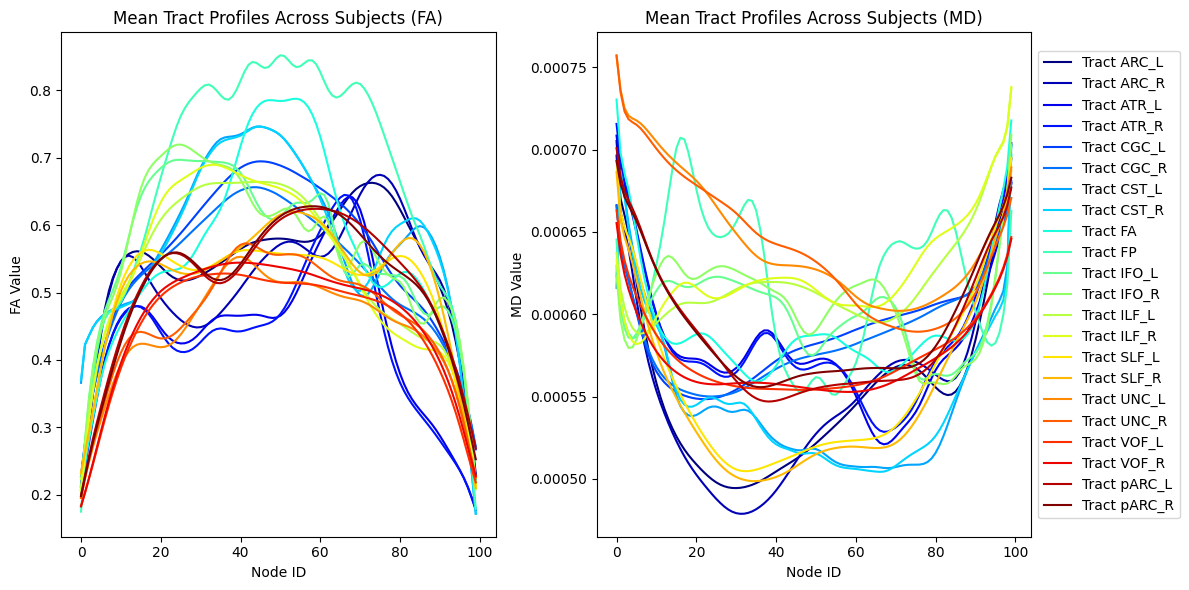

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(11, 6))  # 1 row, 2 columns

# Plot for FA values
axs[0].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 11)))
unique_tract_ids_fa = average_fa_values['tractID'].unique()
for tract_id in unique_tract_ids_fa:
    tract_data = average_fa_values[average_fa_values['tractID'] == tract_id]
    axs[0].plot(tract_data['nodeID'], tract_data['dti_fa'], label=f'Tract {tract_id}')
axs[0].set_xlabel('Node ID')
axs[0].set_ylabel('FA Value')
axs[0].set_title('Mean Tract Profiles Across Subjects (FA)')
#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for MD values
axs[1].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 11)))
unique_tract_ids_md = average_md_values['tractID'].unique()
for tract_id in unique_tract_ids_md:
    tract_data = average_md_values[average_md_values['tractID'] == tract_id]
    axs[1].plot(tract_data['nodeID'], tract_data['dti_md'], label=f'Tract {tract_id}')
axs[1].set_xlabel('Node ID')
axs[1].set_ylabel('MD Value')
axs[1].set_title('Mean Tract Profiles Across Subjects (MD)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Visualize Age Effects

In [7]:
# load GAM results for dti_fa and dti_md
gam_age_dti_fa = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/GAM/dti_fa/GAMresults.dti_fa.age.csv")
gam_age_dti_fa = gam_age_dti_fa.drop(columns=gam_age_dti_fa.columns[0])

gam_age_md = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/GAM/dti_md/GAMresults.dti_md.age.csv")
gam_age_md = gam_age_md.drop(columns=gam_age_md.columns[0])


In [8]:
# determine correct age effect sign for delta adjusted Rsq using equivalent linear model
# load linear models
lm_age_dti_fa = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/GAM/dti_fa/LinearModelresults.dti_fa.age.csv")
lm_age_md = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/GAM/dti_md/LinearModelresults.dti_md.age.csv")
 

In [9]:

# take absolute value of delta adj rsq  
gam_age_dti_fa["s_age.delta.adj.rsq_signed"] = gam_age_dti_fa["s_age.delta.adj.rsq"].abs()
gam_age_md["s_age.delta.adj.rsq_signed"] = gam_age_md["s_age.delta.adj.rsq"].abs()
 
# apply the sign of linear model age estimate (t-value) to GAM delta adj rsq
gam_age_dti_fa["s_age.delta.adj.rsq_signed"] = gam_age_dti_fa["s_age.delta.adj.rsq_signed"] * lm_age_dti_fa['age.estimate'].apply(lambda x: 1 if x >= 0 else -1)
gam_age_md["s_age.delta.adj.rsq_signed"] = gam_age_md["s_age.delta.adj.rsq_signed"] * lm_age_md['age.estimate'].apply(lambda x: 1 if x >= 0 else -1)
 

In [11]:
# How many nodes have significant age effect after FDR?
dti_fa_significant_count = (gam_age_dti_fa['s_age.p.value.fdr'] < 0.05).sum()
md_significant_count = (gam_age_md['s_age.p.value.fdr'] < 0.05).sum()
 
total_nodes = 2200

print(f"dti_fa: {dti_fa_significant_count} nodes ({round(dti_fa_significant_count / total_nodes * 100, 2)}%) with significant age effect after FDR correction")
print(f"md: {md_significant_count} nodes ({round(md_significant_count / total_nodes * 100, 2)}%) with significant age effect after FDR correction")
 

dti_fa: 1087 nodes (49.41%) with significant age effect after FDR correction
md: 2191 nodes (99.59%) with significant age effect after FDR correction


In [12]:
# Add tractID and nodeID to GAM outputs
tract_IDs = pd.read_csv("/cbica/projects/luo_wm_dev/input/HCPD/HCPD_tractprofiles/sub-0001305/sub-0001305_ses-V1_space-T1w_desc-preproc_dwi_space-RASMM_model-probCSD_algo-AFQ_desc-profiles_dwi.csv")
gam_age_dti_fa.insert(0, 'nodeID', tract_IDs['nodeID'])
gam_age_dti_fa.insert(0, 'tractID', tract_IDs['tractID'])

gam_age_md.insert(0, 'nodeID', tract_IDs['nodeID'])
gam_age_md.insert(0, 'tractID', tract_IDs['tractID'])



In [44]:
gam_age_dti_fa

,tractID,nodeID,element_id,s_age.statistic,s_age.p.value,s_age.p.value.fdr,Intercept.estimate,sexM.estimate,mean_fd.estimate,Intercept.statistic,sexM.statistic,mean_fd.statistic,Intercept.p.value,Intercept.p.value.fdr,sexM.p.value,sexM.p.value.fdr,mean_fd.p.value,mean_fd.p.value.fdr,model.dev.expl,s_age.delta.adj.rsq,s_age.partial.rsq,s_age.delta.adj.rsq_signed
0,ATR_L,0,0,7.052165,9.440763e-04,0.002687,0.225938,-0.002458,-0.023118,78.708271,-1.721019,-4.424476,2.393108e-306,5.243861e-306,0.085796,0.264182,1.160657e-05,1.329920e-04,0.070437,0.020020,0.024398,0.020020
1,ATR_L,1,1,7.057790,9.389089e-04,0.002676,0.265773,-0.001061,-0.031140,89.148405,-0.715276,-5.738384,0.000000e+00,0.000000e+00,0.474735,0.714229,1.561380e-08,4.461085e-07,0.095685,0.019495,0.024417,0.019495
2,ATR_L,2,2,10.564710,3.145240e-05,0.000120,0.304126,0.000478,-0.037040,90.642880,0.286323,-6.064921,0.000000e+00,0.000000e+00,0.774736,0.901332,2.420254e-09,8.904074e-08,0.122211,0.029878,0.036111,0.029878
3,ATR_L,3,3,17.943709,0.000000e+00,0.000000,0.340194,0.001719,-0.041548,92.368975,0.938155,-6.197569,0.000000e+00,0.000000e+00,0.348566,0.611520,1.107533e-09,4.685717e-08,0.158301,0.050751,0.059824,0.050751
4,ATR_L,4,4,25.434261,0.000000e+00,0.000000,0.373082,0.003193,-0.046546,96.159617,1.654118,-6.590828,0.000000e+00,0.000000e+00,0.098660,0.286727,1.005594e-10,5.267399e-09,0.196758,0.069844,0.082731,0.069844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,VOF_R,95,2195,15.186322,6.405106e-07,0.000003,0.333059,0.000461,-0.035209,60.276819,0.167797,-3.500672,5.503454e-248,6.741425e-248,0.866803,0.945688,5.007840e-04,2.720308e-03,0.096772,0.045598,0.051100,0.045598
2196,VOF_R,96,2196,13.170851,2.905571e-06,0.000013,0.309115,0.000459,-0.030760,59.031810,0.176179,-3.227234,1.427632e-243,1.700482e-243,0.860217,0.943673,1.322457e-03,5.649332e-03,0.084684,0.039644,0.044621,0.039644
2197,VOF_R,97,2197,11.398944,1.466357e-05,0.000060,0.284268,0.000220,-0.025872,57.912793,0.090129,-2.895715,1.512365e-239,1.741991e-239,0.928217,0.968268,3.929572e-03,1.280749e-02,0.072691,0.034316,0.038851,0.034316
2198,VOF_R,98,2198,10.425860,3.597635e-05,0.000136,0.259529,-0.000020,-0.020842,55.711903,-0.008579,-2.457925,1.819704e-231,2.009713e-231,0.993158,0.997816,1.427392e-02,3.504757e-02,0.062708,0.031440,0.035653,0.031440


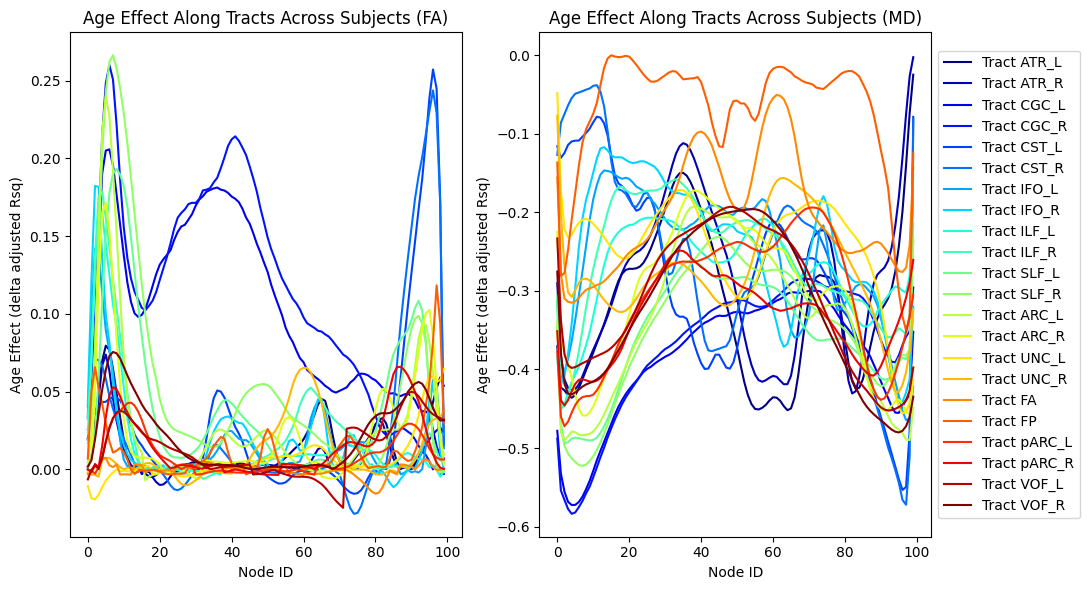

In [14]:
# Plot age effect for all tracts

fig, axs = plt.subplots(1, 2, figsize=(11, 6))  # 1 row, 2 columns

# Plot for FA values
axs[0].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 22)))
unique_tract_ids_fa = gam_age_dti_fa['tractID'].unique()
for tract_id in unique_tract_ids_fa:
    tract_data = gam_age_dti_fa[gam_age_dti_fa['tractID'] == tract_id]
    axs[0].plot(tract_data['nodeID'], tract_data['s_age.delta.adj.rsq_signed'], label=f'Tract {tract_id}')
axs[0].set_xlabel('Node ID')
axs[0].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[0].set_title('Age Effect Along Tracts Across Subjects (FA)')
#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for MD values
axs[1].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 22)))
unique_tract_ids_md = gam_age_md['tractID'].unique()
for tract_id in unique_tract_ids_md:
    tract_data = gam_age_md[gam_age_md['tractID'] == tract_id]
    axs[1].plot(tract_data['nodeID'], tract_data['s_age.delta.adj.rsq_signed'], label=f'Tract {tract_id}')
axs[1].set_xlabel('Node ID')
axs[1].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[1].set_title('Age Effect Along Tracts Across Subjects (MD)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

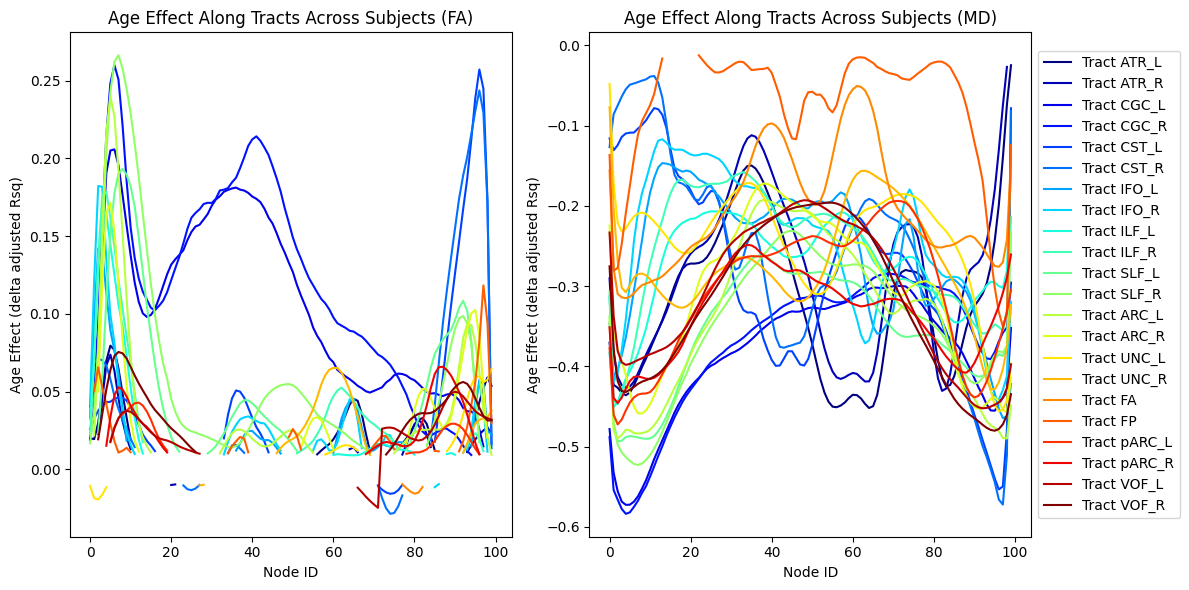

In [58]:

# for plotting, NaN out values where FDR-correct pval >= 0.05
#gam_age_dti_fa.loc[gam_age_dti_fa['s_age.p.value.fdr'] >= 0.05, 's_age.delta.adj.rsq_signed'] = np.nan
#gam_age_md.loc[gam_age_md['s_age.p.value.fdr'] >= 0.05, 's_age.delta.adj.rsq_signed'] = np.nan


fig, axs = plt.subplots(1, 2, figsize=(11, 6))  # 1 row, 2 columns

# Plot for FA values
axs[0].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 11)))
unique_tract_ids_fa = gam_age_dti_fa['tractID'].unique()
for tract_id in unique_tract_ids_fa:
    tract_data = gam_age_dti_fa[gam_age_dti_fa['tractID'] == tract_id]
    axs[0].plot(tract_data['nodeID'], tract_data['s_age.delta.adj.rsq_signed'], label=f'Tract {tract_id}')
axs[0].set_xlabel('Node ID')
axs[0].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[0].set_title('Age Effect Along Tracts Across Subjects (FA)')
#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for MD values
axs[1].set_prop_cycle('color', plt.cm.jet(np.linspace(0, 1, 11)))
unique_tract_ids_md = gam_age_md['tractID'].unique()
for tract_id in unique_tract_ids_md:
    tract_data = gam_age_md[gam_age_md['tractID'] == tract_id]
    axs[1].plot(tract_data['nodeID'], tract_data['s_age.delta.adj.rsq_signed'], label=f'Tract {tract_id}')
axs[1].set_xlabel('Node ID')
axs[1].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[1].set_title('Age Effect Along Tracts Across Subjects (MD)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [74]:
gam_age_dti_fa['tractID'].unique()

array(['ATR_L', 'ATR_R', 'CGC_L', 'CGC_R', 'CST_L', 'CST_R', 'IFO_L',
       'IFO_R', 'ILF_L', 'ILF_R', 'SLF_L', 'SLF_R', 'ARC_L', 'ARC_R',
       'UNC_L', 'UNC_R', 'FA', 'FP', 'pARC_L', 'pARC_R', 'VOF_L', 'VOF_R'],
      dtype=object)

In [80]:
gam_age_dti_fa

,tractID,nodeID,element_id,s_age.statistic,s_age.p.value,s_age.p.value.fdr,Intercept.estimate,sexM.estimate,mean_fd.estimate,Intercept.statistic,sexM.statistic,mean_fd.statistic,Intercept.p.value,Intercept.p.value.fdr,sexM.p.value,sexM.p.value.fdr,mean_fd.p.value,mean_fd.p.value.fdr,model.dev.expl,s_age.delta.adj.rsq,s_age.partial.rsq,s_age.delta.adj.rsq_signed
0,ATR_L,0,0,7.052165,9.440763e-04,0.002687,0.225938,-0.002458,-0.023118,78.708271,-1.721019,-4.424476,2.393108e-306,5.243861e-306,0.085796,0.264182,1.160657e-05,1.329920e-04,0.070437,0.020020,0.024398,0.020020
1,ATR_L,1,1,7.057790,9.389089e-04,0.002676,0.265773,-0.001061,-0.031140,89.148405,-0.715276,-5.738384,0.000000e+00,0.000000e+00,0.474735,0.714229,1.561380e-08,4.461085e-07,0.095685,0.019495,0.024417,0.019495
2,ATR_L,2,2,10.564710,3.145240e-05,0.000120,0.304126,0.000478,-0.037040,90.642880,0.286323,-6.064921,0.000000e+00,0.000000e+00,0.774736,0.901332,2.420254e-09,8.904074e-08,0.122211,0.029878,0.036111,0.029878
3,ATR_L,3,3,17.943709,0.000000e+00,0.000000,0.340194,0.001719,-0.041548,92.368975,0.938155,-6.197569,0.000000e+00,0.000000e+00,0.348566,0.611520,1.107533e-09,4.685717e-08,0.158301,0.050751,0.059824,0.050751
4,ATR_L,4,4,25.434261,0.000000e+00,0.000000,0.373082,0.003193,-0.046546,96.159617,1.654118,-6.590828,0.000000e+00,0.000000e+00,0.098660,0.286727,1.005594e-10,5.267399e-09,0.196758,0.069844,0.082731,0.069844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,VOF_R,95,2195,15.186322,6.405106e-07,0.000003,0.333059,0.000461,-0.035209,60.276819,0.167797,-3.500672,5.503454e-248,6.741425e-248,0.866803,0.945688,5.007840e-04,2.720308e-03,0.096772,0.045598,0.051100,0.045598
2196,VOF_R,96,2196,13.170851,2.905571e-06,0.000013,0.309115,0.000459,-0.030760,59.031810,0.176179,-3.227234,1.427632e-243,1.700482e-243,0.860217,0.943673,1.322457e-03,5.649332e-03,0.084684,0.039644,0.044621,0.039644
2197,VOF_R,97,2197,11.398944,1.466357e-05,0.000060,0.284268,0.000220,-0.025872,57.912793,0.090129,-2.895715,1.512365e-239,1.741991e-239,0.928217,0.968268,3.929572e-03,1.280749e-02,0.072691,0.034316,0.038851,0.034316
2198,VOF_R,98,2198,10.425860,3.597635e-05,0.000136,0.259529,-0.000020,-0.020842,55.711903,-0.008579,-2.457925,1.819704e-231,2.009713e-231,0.993158,0.997816,1.427392e-02,3.504757e-02,0.062708,0.031440,0.035653,0.031440


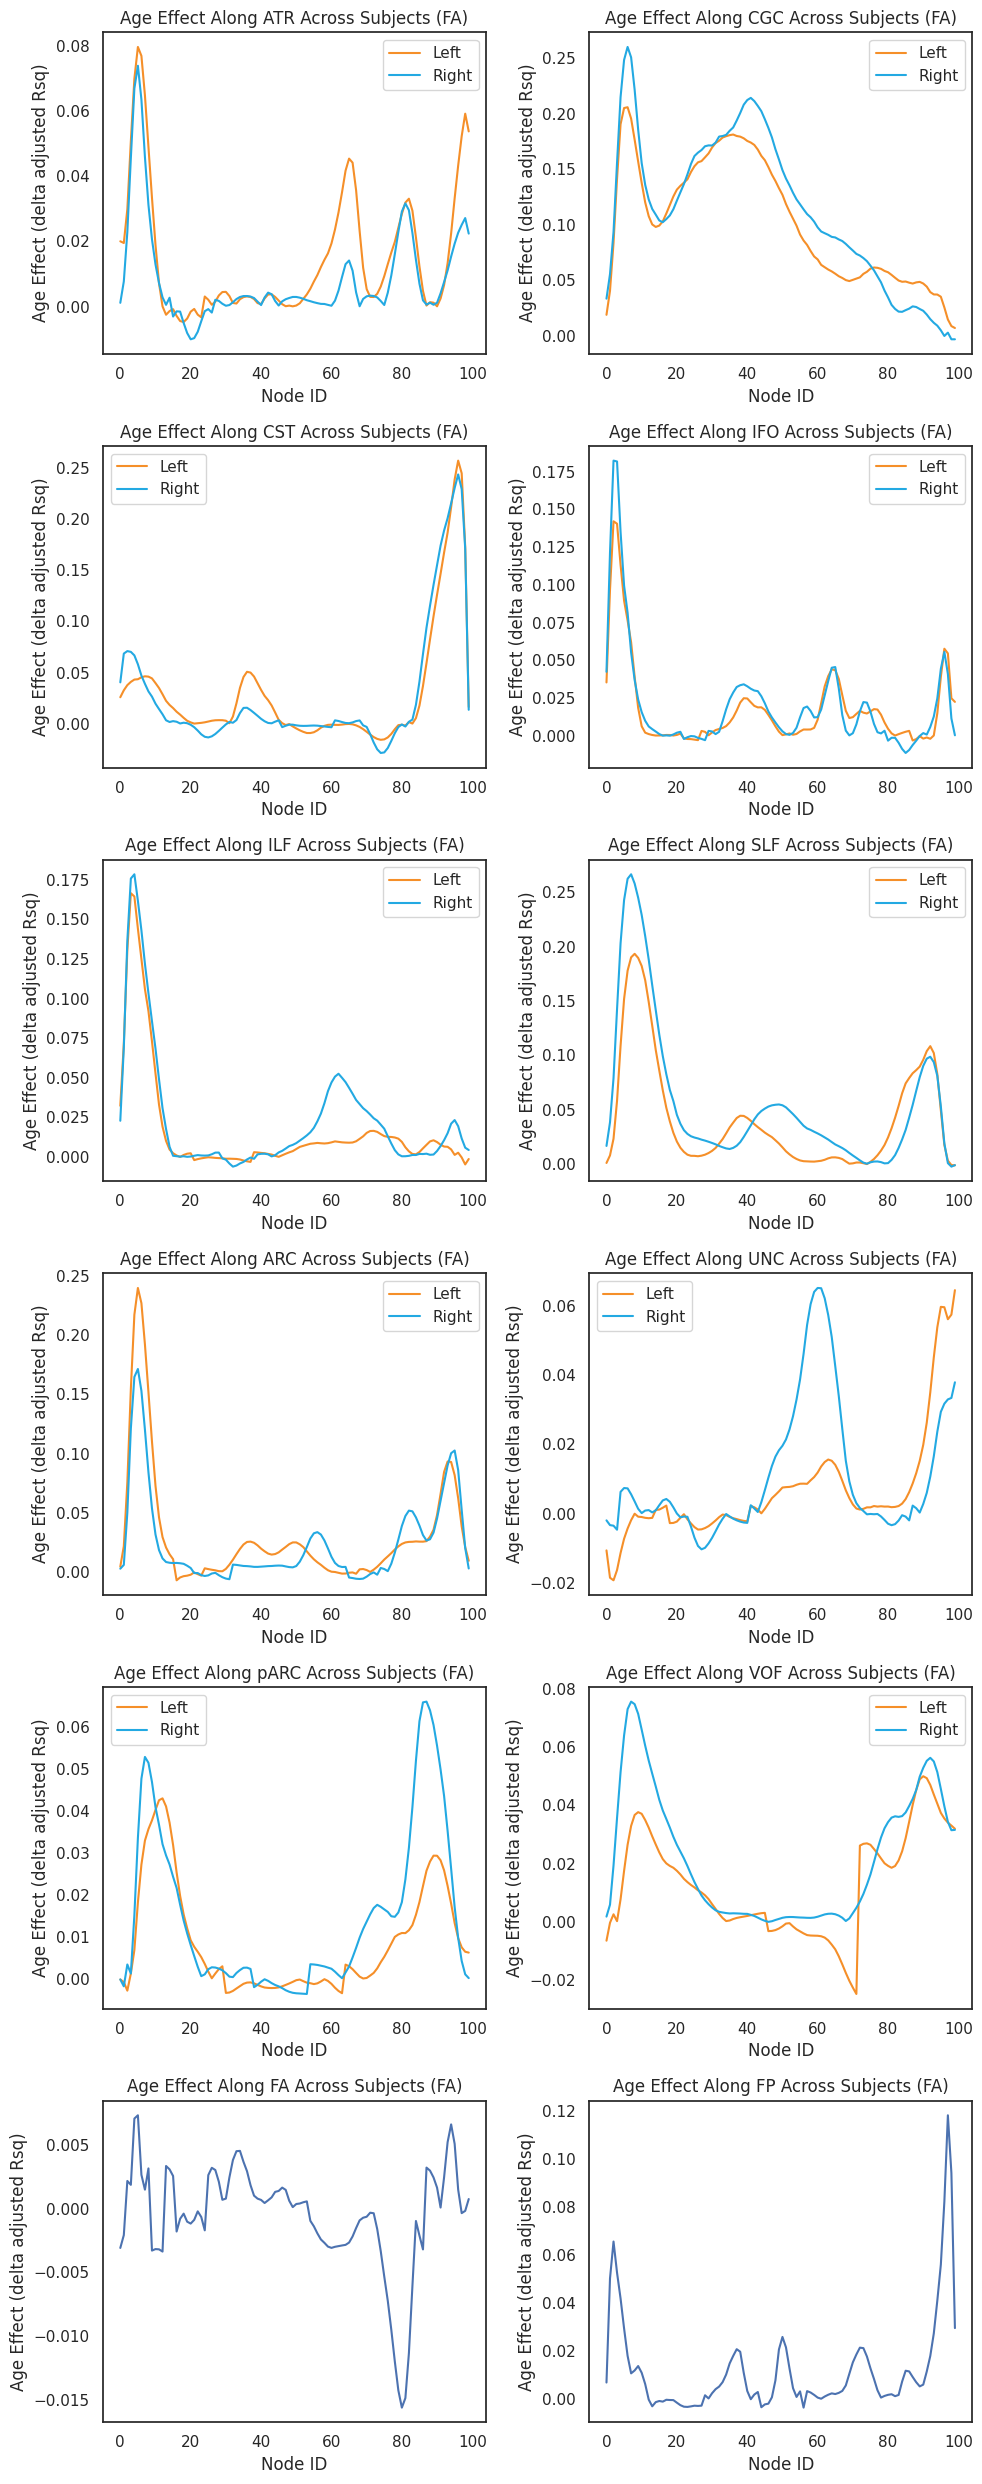

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set_theme(style="white")

tracts = ['ATR', 'CGC', 'CST', 'IFO', 'ILF', 'SLF', 'ARC', 'UNC', 'pARC', 'VOF']
num_rows = len(tracts) + 2
num_cols = 2

fig, axs = plt.subplots(num_rows // 2, num_cols, figsize=(10, 25))

for i, tract in enumerate(tracts):
    ax = axs[i // num_cols, i % num_cols]  # Correct indexing to access the Axes object
    tract_data_left = gam_age_dti_fa[gam_age_dti_fa['tractID'] == f'{tract}_L']
    tract_data_right = gam_age_dti_fa[gam_age_dti_fa['tractID'] == f'{tract}_R']
    sns.lineplot(data=tract_data_left, x='nodeID', y='s_age.delta.adj.rsq_signed',  color = "#F58F29", ax=ax, label='Left')
    sns.lineplot(data=tract_data_right, x='nodeID', y='s_age.delta.adj.rsq_signed', color = "#23A9E2", ax=ax, label='Right')
    ax.set_xlabel('Node ID')
    ax.set_ylabel('Age Effect (delta adjusted Rsq)')
    ax.set_title(f'Age Effect Along {tract} Across Subjects (FA)')
    ax.legend()

# Plotting additional data for 'FA' and 'FP' tracts
tract_data = gam_age_dti_fa[gam_age_dti_fa['tractID'] == 'FA']
sns.lineplot(data=tract_data, x='nodeID', y='s_age.delta.adj.rsq_signed', ax=axs[10 // num_cols, 10 % num_cols])
axs[10 // num_cols, 10 % num_cols].set_xlabel('Node ID')
axs[10 // num_cols, 10 % num_cols].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[10 // num_cols, 10 % num_cols].set_title(f'Age Effect Along FA Across Subjects (FA)')

tract_data = gam_age_dti_fa[gam_age_dti_fa['tractID'] == 'FP']
sns.lineplot(data=tract_data, x='nodeID', y='s_age.delta.adj.rsq_signed',  ax=axs[11 // num_cols, 11 % num_cols])
axs[11 // num_cols, 11 % num_cols].set_xlabel('Node ID')
axs[11 // num_cols, 11 % num_cols].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[11 // num_cols, 11 % num_cols].set_title(f'Age Effect Along FP Across Subjects (FA)')

plt.tight_layout()
plt.show()

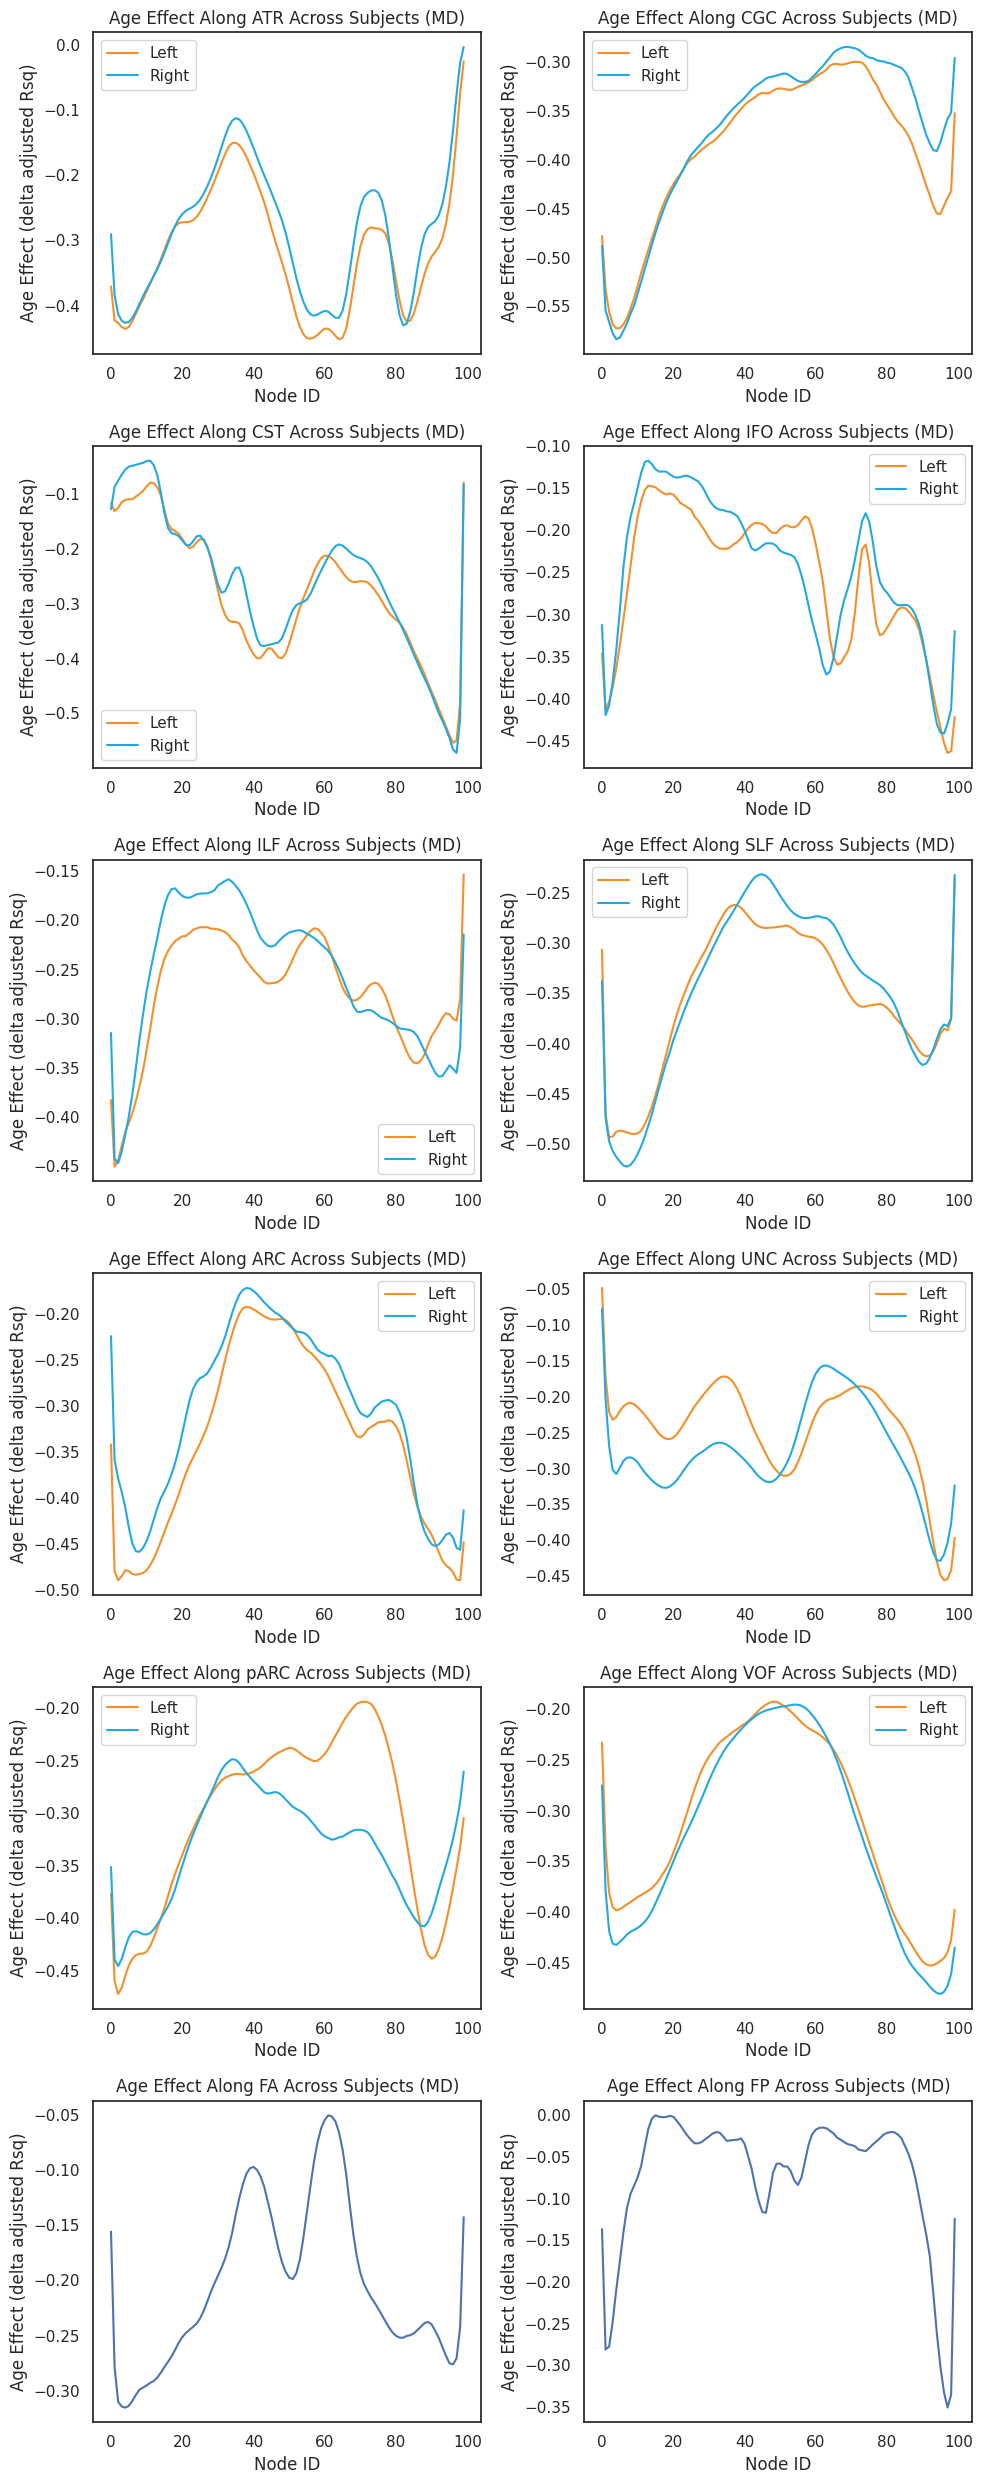

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set_theme(style="white")

tracts = ['ATR', 'CGC', 'CST', 'IFO', 'ILF', 'SLF', 'ARC', 'UNC', 'pARC', 'VOF']
num_rows = len(tracts) + 2
num_cols = 2

fig, axs = plt.subplots(num_rows // 2, num_cols, figsize=(10, 25))

for i, tract in enumerate(tracts):
    ax = axs[i // num_cols, i % num_cols]  # Correct indexing to access the Axes object
    tract_data_left = gam_age_md[gam_age_md['tractID'] == f'{tract}_L']
    tract_data_right = gam_age_md[gam_age_md['tractID'] == f'{tract}_R']
    sns.lineplot(data=tract_data_left, x='nodeID', y='s_age.delta.adj.rsq_signed',  color = "#F58F29", ax=ax, label='Left')
    sns.lineplot(data=tract_data_right, x='nodeID', y='s_age.delta.adj.rsq_signed', color = "#23A9E2", ax=ax, label='Right')
    ax.set_xlabel('Node ID')
    ax.set_ylabel('Age Effect (delta adjusted Rsq)')
    ax.set_title(f'Age Effect Along {tract} Across Subjects (MD)')
    ax.legend()

# Plotting additional data for 'FA' and 'FP' tracts
tract_data = gam_age_md[gam_age_md['tractID'] == 'FA']
sns.lineplot(data=tract_data, x='nodeID', y='s_age.delta.adj.rsq_signed', ax=axs[10 // num_cols, 10 % num_cols])
axs[10 // num_cols, 10 % num_cols].set_xlabel('Node ID')
axs[10 // num_cols, 10 % num_cols].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[10 // num_cols, 10 % num_cols].set_title(f'Age Effect Along FA Across Subjects (MD)')

tract_data = gam_age_md[gam_age_md['tractID'] == 'FP']
sns.lineplot(data=tract_data, x='nodeID', y='s_age.delta.adj.rsq_signed',  ax=axs[11 // num_cols, 11 % num_cols])
axs[11 // num_cols, 11 % num_cols].set_xlabel('Node ID')
axs[11 // num_cols, 11 % num_cols].set_ylabel('Age Effect (delta adjusted Rsq)')
axs[11 // num_cols, 11 % num_cols].set_title(f'Age Effect Along FP Across Subjects (MD)')

plt.tight_layout()
plt.show()